In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# after

In [ ]:
after = pd.read_csv('./data/after_vital_ventset_gcs_abga.csv')

In [ ]:
# 삽관 중에 변수가 없는 행 제외
after = data[~(data[['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate',
       'temperature', 'temperature_site', 'spo2', 'glucose',
       'respiratory_rate_set', 'respiratory_rate_total',
       'respiratory_rate_spontaneous', 'minute_volume', 'tidal_volume_set',
       'tidal_volume_observed', 'tidal_volume_spontaneous', 'plateau_pressure',
       'peep', 'fio2', 'flow_rate', 'ventilator_mode',
       'ventilator_mode_hamilton', 'ventilator_type', 'ventilator_scoring',
       'gcs', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs_unable', 'pCO2',
       'pO2', 'SaO2', 'HCO3-', 'pH', 'Base excess']].isna().sum(axis = 1) == 35)]

In [ ]:
after = after.drop(columns = ['admittime', 'dischtime', 'intubationtime', 'extubationtime', 'charttime','subject_id', 'hadm_id', 'stay_id','Unnamed: 0','class_code'])

In [ ]:
# 데이터 타입이 object인 컬럼 제외
after = after.drop(columns = ['ventilator_mode', 'ventilator_mode_hamilton', 'ventilator_type', 'temperature_site', 'extubationcause','mvtime_state'])

<AxesSubplot:xlabel='class'>

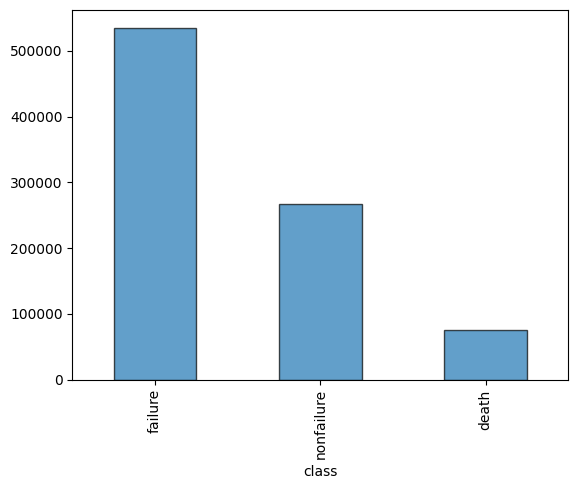

In [ ]:
after['class'].value_counts().plot(kind = 'bar', edgecolor = 'k', alpha = 0.7)


In [ ]:
# class가 nan인 건 제외
after = after[~(after['class'].isna())]

In [ ]:
# gender 맵핑
mapping_dict_gender = {'F':1,'M':0}
after.gender = after.gender.apply(lambda x : mapping_dict_gender[x])

In [ ]:
# class 맵핑
mapping_dict_class = {'failure':0, 'nonfailure':1, 'death': 2}
after['class'] = after['class'].apply(lambda x : mapping_dict_class[x])

In [ ]:
after['class'] = after['class'].astype('category')

In [ ]:
# 결측치 0으로 채움

after = after.fillna(0)

In [ ]:
after.info()

<class 'pandas.core.frame.DataFrame'>
Index: 878683 entries, 0 to 901658
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   los                           878683 non-null  float64 
 1   gender                        878683 non-null  category
 2   mvtime                        878683 non-null  float64 
 3   seq_num                       878683 non-null  int64   
 4   class                         878683 non-null  category
 5   heart_rate                    878683 non-null  float64 
 6   sbp                           878683 non-null  float64 
 7   dbp                           878683 non-null  float64 
 8   mbp                           878683 non-null  float64 
 9   resp_rate                     878683 non-null  float64 
 10  temperature                   878683 non-null  float64 
 11  spo2                          878683 non-null  float64 
 12  glucose                       87868

## model

In [ ]:
#target 과 X 를 분리함.
X = after.drop(columns="class", axis=1)
y = after['class']
print(X.shape, y.shape)

(878683, 35) (878683,)


In [53]:
from sklearn.model_selection import train_test_split
seed = 88

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(702946, 35) (175737, 35) (702946,) (175737,)


In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702946 entries, 544960 to 227350
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   los                           702946 non-null  float64 
 1   gender                        702946 non-null  category
 2   mvtime                        702946 non-null  float64 
 3   seq_num                       702946 non-null  int64   
 4   heart_rate                    702946 non-null  float64 
 5   sbp                           702946 non-null  float64 
 6   dbp                           702946 non-null  float64 
 7   mbp                           702946 non-null  float64 
 8   resp_rate                     702946 non-null  float64 
 9   temperature                   702946 non-null  float64 
 10  spo2                          702946 non-null  float64 
 11  glucose                       702946 non-null  float64 
 12  respiratory_rate_set          

In [55]:
# smote
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=seed).fit_resample(X, y)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)
print(X_train_smote.shape, X_test_smote.shape, y_train_smote.shape, y_test_smote.shape)

(1285257, 35) (321315, 35) (1285257,) (321315,)


In [56]:
# under
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler(random_state=seed).fit_resample(X, y)

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)
print(X_train_under.shape, X_test_under.shape, y_train_under.shape, y_test_under.shape)

(181915, 35) (45479, 35) (181915,) (45479,)


Class=0, n=75798 (33.333%)
Class=1, n=75798 (33.333%)
Class=2, n=75798 (33.333%)


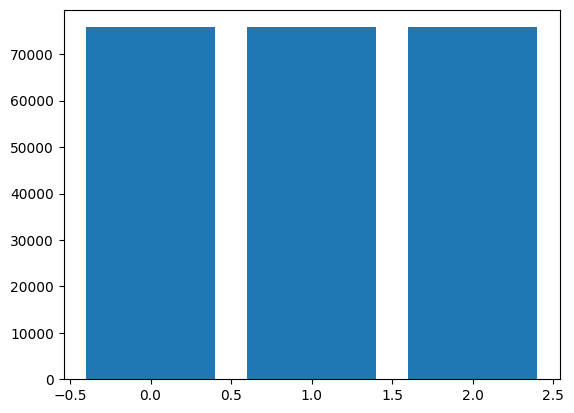

In [57]:
from collections import Counter
from matplotlib import pyplot

def count_and_plot(y):
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

count_and_plot(y_resampled)

### LGBClassifier

In [59]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import classification_report

lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train, y_train)

pred_lgb = lgb.predict(X_test)
print(classification_report(y_test, pred_lgb)) # 0.74

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 702946, number of used features: 35
[LightGBM] [Info] Start training from score -0.495178
[LightGBM] [Info] Start training from score -1.189823
[LightGBM] [Info] Start training from score -2.450358
              precision    recall  f1-score   support

           0       0.75      0.92      0.83    107105
           1       0.69      0.46      0.55     53472
           2       0.80      0.48      0.60     15160

    accuracy                           0.74    175737
   macro avg       0.75      0.62      0.66    175737
weighted avg       0.74      0.74      0.72    175737



In [60]:
# smote
lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train_smote, y_train_smote)

pred_lgb_smote = lgb.predict(X_test_smote)
print(classification_report(y_test_smote, pred_lgb_smote)) #  0.74

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8454
[LightGBM] [Info] Number of data points in the train set: 1285257, number of used features: 35
[LightGBM] [Info] Start training from score -1.098636
[LightGBM] [Info] Start training from score -1.099563
[LightGBM] [Info] Start training from score -1.097639
              precision    recall  f1-score   support

           0       0.71      0.83      0.77    107115
           1       0.70      0.59      0.64    107512
           2       0.82      0.81      0.81    106688

    accuracy                           0.74    321315
   macro avg       0.74      0.74      0.74    321315
weighted avg       0.74      0.74      0.74    321315



In [61]:
# under
lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train_under, y_train_under)

pred_lgb_under = lgb.predict(X_test_under)
print(classification_report(y_test_under, pred_lgb_under)) # 0.70

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4116
[LightGBM] [Info] Number of data points in the train set: 181915, number of used features: 35
[LightGBM] [Info] Start training from score -1.097530
[LightGBM] [Info] Start training from score -1.099327
[LightGBM] [Info] Start training from score -1.098981
              precision    recall  f1-score   support

           0       0.66      0.74      0.70     15094
           1       0.65      0.56      0.60     15203
           2       0.79      0.81      0.80     15182

    accuracy                           0.70     45479
   macro avg       0.70      0.70      0.70     45479
weighted avg       0.70      0.70      0.70     45479



### RandomForestClassifier

In [62]:
# 아무것도 안 함
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf)) # 0.88

              precision    recall  f1-score   support

           0       0.87      0.96      0.92    107105
           1       0.89      0.75      0.82     53472
           2       0.94      0.74      0.83     15160

    accuracy                           0.88    175737
   macro avg       0.90      0.82      0.85    175737
weighted avg       0.88      0.88      0.88    175737



In [63]:
# smote
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train_smote, y_train_smote)

pred_rf_smote = rf.predict(X_test_smote)
print(classification_report(y_test_smote, pred_rf_smote)) # 0.91

              precision    recall  f1-score   support

           0       0.89      0.93      0.90    107115
           1       0.90      0.86      0.88    107512
           2       0.95      0.95      0.95    106688

    accuracy                           0.91    321315
   macro avg       0.91      0.91      0.91    321315
weighted avg       0.91      0.91      0.91    321315



In [64]:
# under
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train_under, y_train_under)

pred_rf_under = rf.predict(X_test_under)
print(classification_report(y_test_under, pred_rf_under)) # 0.80

              precision    recall  f1-score   support

           0       0.76      0.79      0.77     15094
           1       0.76      0.71      0.74     15203
           2       0.87      0.89      0.88     15182

    accuracy                           0.80     45479
   macro avg       0.80      0.80      0.80     45479
weighted avg       0.80      0.80      0.80     45479



In [65]:
# Cost sensitive
weights = {0:1.0, 1:1.5, 2:2.0}
rf = RandomForestClassifier(random_state = seed, class_weight=weights)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf)) # 0.87

              precision    recall  f1-score   support

           0       0.86      0.96      0.91    107105
           1       0.88      0.73      0.80     53472
           2       0.93      0.73      0.82     15160

    accuracy                           0.87    175737
   macro avg       0.89      0.81      0.84    175737
weighted avg       0.87      0.87      0.87    175737



### XGBoost

In [72]:
# XGBBoost
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(random_state = seed, enable_categorical= True)
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, pred_xgb)) # 0.78

              precision    recall  f1-score   support

           0       0.78      0.93      0.85    107105
           1       0.74      0.53      0.62     53472
           2       0.86      0.57      0.68     15160

    accuracy                           0.78    175737
   macro avg       0.79      0.67      0.72    175737
weighted avg       0.77      0.78      0.76    175737



In [74]:
# smote
xgb = XGBClassifier(random_state = seed, enable_categorical =  True)
xgb.fit(X_train_smote, y_train_smote)

pred_xgb_smote = xgb.predict(X_test_smote)
print(classification_report(y_test_smote, pred_xgb_smote)) #  0.77

              precision    recall  f1-score   support

           0       0.75      0.85      0.80    107115
           1       0.75      0.65      0.69    107512
           2       0.85      0.84      0.85    106688

    accuracy                           0.78    321315
   macro avg       0.78      0.78      0.78    321315
weighted avg       0.78      0.78      0.78    321315



In [75]:
# under
xgb = XGBClassifier(random_state = seed, enable_categorical = True)
xgb.fit(X_train_under, y_train_under)

pred_xgb_under = xgb.predict(X_test_under)
print(classification_report(y_test_under, pred_xgb_under)) # 0.75

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     15094
           1       0.70      0.64      0.67     15203
           2       0.84      0.85      0.85     15182

    accuracy                           0.75     45479
   macro avg       0.75      0.75      0.75     45479
weighted avg       0.75      0.75      0.75     45479



# before

In [3]:
before = pd.read_csv('./data/before_vital_ventset_gcs_abga.csv')

In [4]:
before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572622 entries, 0 to 572621
Data columns (total 52 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    572622 non-null  int64  
 1   subject_id                    572622 non-null  int64  
 2   hadm_id                       572622 non-null  int64  
 3   stay_id                       572622 non-null  float64
 4   los                           572622 non-null  float64
 5   gender                        572622 non-null  object 
 6   admittime                     544696 non-null  object 
 7   dischtime                     572622 non-null  object 
 8   intubationtime                572622 non-null  object 
 9   extubationtime                572622 non-null  object 
 10  extubationcause               412569 non-null  object 
 11  mvtime                        544696 non-null  float64
 12  seq_num                       572622 non-nul

In [6]:
# 삽관 중에 변수가 없는 행 제외
before = before[~(before[['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate',
       'temperature', 'temperature_site', 'spo2', 'glucose',
       'respiratory_rate_set', 'respiratory_rate_total',
       'respiratory_rate_spontaneous', 'minute_volume', 'tidal_volume_set',
       'tidal_volume_observed', 'tidal_volume_spontaneous', 'plateau_pressure',
       'peep', 'fio2', 'flow_rate', 'ventilator_mode',
       'ventilator_mode_hamilton', 'ventilator_type', 'ventilator_scoring',
       'gcs', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs_unable', 'pCO2',
       'pO2', 'SaO2', 'HCO3-', 'pH', 'Base excess']].isna().sum(axis = 1) == 35)]

In [7]:
before = before.drop(columns = ['admittime', 'dischtime', 'intubationtime', 'extubationtime', 'charttime','subject_id', 'hadm_id', 'stay_id','Unnamed: 0','class_code'])

In [8]:
# 데이터 타입이 object인 컬럼 제외
before = before.drop(columns = ['ventilator_mode', 'ventilator_mode_hamilton', 'ventilator_type', 'temperature_site', 'extubationcause','mvtime_state'])

<AxesSubplot:xlabel='class'>

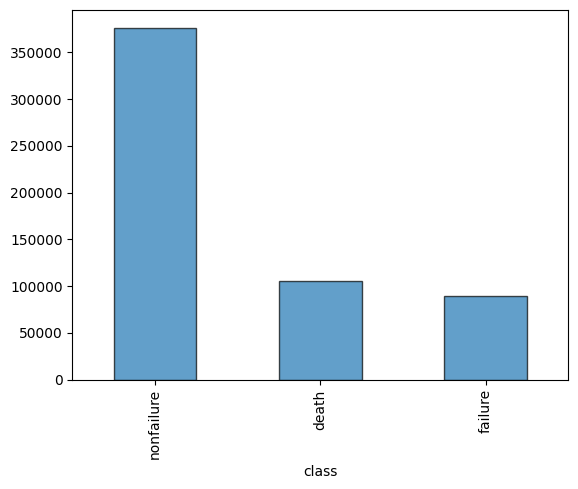

In [9]:
before['class'].value_counts().plot(kind = 'bar', edgecolor = 'k', alpha = 0.7)


In [10]:
# class가 nan인 건 제외
before = before[~(before['class'].isna())]

In [11]:
# gender 맵핑
mapping_dict_gender = {'F':1,'M':0}
before.gender = before.gender.apply(lambda x : mapping_dict_gender[x])

In [12]:
# class 맵핑
mapping_dict_class = {'failure':0,'nonfailure':1, 'death': 2}
before['class'] = before['class'].apply(lambda x : mapping_dict_class[x])

In [13]:
before.gender = before.gender.astype('category')
before['class'] = before['class'].astype('category')

In [14]:
# 결측치 0으로 채움
before = before.fillna(0)

## model

In [15]:
#target 과 X 를 분리함.
X = before.drop(columns="class", axis=1)
y = before['class']
print(X.shape, y.shape)

(571749, 35) (571749,)


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571749 entries, 0 to 572621
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   los                           571749 non-null  float64 
 1   gender                        571749 non-null  category
 2   mvtime                        571749 non-null  float64 
 3   seq_num                       571749 non-null  int64   
 4   heart_rate                    571749 non-null  float64 
 5   sbp                           571749 non-null  float64 
 6   dbp                           571749 non-null  float64 
 7   mbp                           571749 non-null  float64 
 8   resp_rate                     571749 non-null  float64 
 9   temperature                   571749 non-null  float64 
 10  spo2                          571749 non-null  float64 
 11  glucose                       571749 non-null  float64 
 12  respiratory_rate_set          57174

In [17]:
from sklearn.model_selection import train_test_split
seed = 88

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(457399, 35) (114350, 35) (457399,) (114350,)


In [18]:
# smote
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=seed).fit_resample(X, y)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)
print(X_train_smote.shape, X_test_smote.shape, y_train_smote.shape, y_test_smote.shape)

(903818, 35) (225955, 35) (903818,) (225955,)


In [19]:
# under
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler(random_state=seed).fit_resample(X, y)

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)
print(X_train_under.shape, X_test_under.shape, y_train_under.shape, y_test_under.shape)

(214812, 35) (53703, 35) (214812,) (53703,)


Class=0, n=89505 (33.333%)
Class=1, n=89505 (33.333%)
Class=2, n=89505 (33.333%)


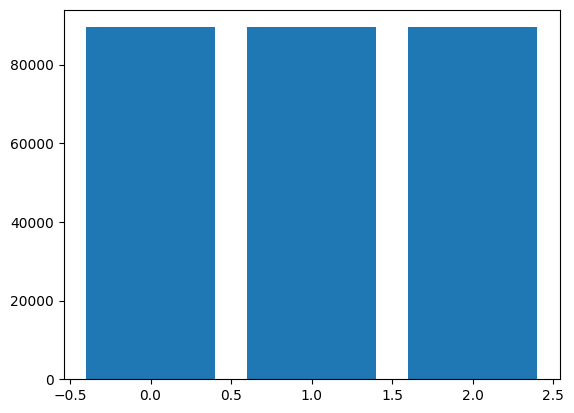

In [20]:
from collections import Counter
from matplotlib import pyplot

def count_and_plot(y):
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

count_and_plot(y_resampled)

### LGBClassifier

In [21]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import classification_report

lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train, y_train)

pred_lgb = lgb.predict(X_test)
print(classification_report(y_test, pred_lgb)) # 0.79

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4014
[LightGBM] [Info] Number of data points in the train set: 457399, number of used features: 35
[LightGBM] [Info] Start training from score -1.854405
[LightGBM] [Info] Start training from score -0.417539
[LightGBM] [Info] Start training from score -1.688544
              precision    recall  f1-score   support

           0       0.74      0.53      0.62     17901
           1       0.79      0.93      0.85     75318
           2       0.84      0.49      0.62     21131

    accuracy                           0.79    114350
   macro avg       0.79      0.65      0.70    114350
weighted avg       0.79      0.79      0.77    114350



In [22]:
# smote
lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train_smote, y_train_smote)

pred_lgb_smote = lgb.predict(X_test_smote)
print(classification_report(y_test_smote, pred_lgb_smote)) #  0.82

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8421
[LightGBM] [Info] Number of data points in the train set: 903818, number of used features: 35
[LightGBM] [Info] Start training from score -1.097818
[LightGBM] [Info] Start training from score -1.098707
[LightGBM] [Info] Start training from score -1.099312
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     75079
           1       0.77      0.77      0.77     75347
           2       0.88      0.80      0.84     75529

    accuracy                           0.82    225955
   macro avg       0.82      0.82      0.82    225955
weighted avg       0.82      0.82      0.82    225955



In [ ]:
# under
lgb = LGBMClassifier(random_state = seed)
lgb.fit(X_train_under, y_train_under)

pred_lgb_under = lgb.predict(X_test_under)
print(classification_report(y_test_under, pred_lgb_under)) # 0.77

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 214812, number of used features: 35
[LightGBM] [Info] Start training from score -1.096743
[LightGBM] [Info] Start training from score -1.099688
[LightGBM] [Info] Start training from score -1.099409
              precision    recall  f1-score   support

           0       0.77      0.91      0.83     17767
           1       0.73      0.61      0.66     17978
           2       0.81      0.80      0.80     17958

    accuracy                           0.77     53703
   macro avg       0.77      0.77      0.77     53703
weighted avg       0.77      0.77      0.77     53703



### RandomForestClassifier

In [24]:
# 아무것도 안 함
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf)) # 0.88

              precision    recall  f1-score   support

           0       0.91      0.69      0.79     17901
           1       0.87      0.97      0.92     75318
           2       0.91      0.72      0.81     21131

    accuracy                           0.88    114350
   macro avg       0.90      0.80      0.84    114350
weighted avg       0.88      0.88      0.88    114350



In [25]:
# smote
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train_smote, y_train_smote)

pred_rf_smote = rf.predict(X_test_smote)
print(classification_report(y_test_smote, pred_rf_smote)) # 0.94

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     75079
           1       0.92      0.92      0.92     75347
           2       0.96      0.94      0.95     75529

    accuracy                           0.94    225955
   macro avg       0.94      0.94      0.94    225955
weighted avg       0.94      0.94      0.94    225955



In [26]:
# under
rf = RandomForestClassifier(random_state = seed)
rf.fit(X_train_under, y_train_under)

pred_rf_under = rf.predict(X_test_under)
print(classification_report(y_test_under, pred_rf_under)) # 0.85

              precision    recall  f1-score   support

           0       0.83      0.92      0.88     17767
           1       0.83      0.74      0.78     17978
           2       0.87      0.88      0.88     17958

    accuracy                           0.85     53703
   macro avg       0.85      0.85      0.84     53703
weighted avg       0.85      0.85      0.84     53703



In [27]:
# Cost sensitive

weights = {0:1.0, 1:1.5, 2:2.0}
rf = RandomForestClassifier(random_state = seed, class_weight=weights)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf)) # 0.87

              precision    recall  f1-score   support

           0       0.89      0.65      0.75     17901
           1       0.85      0.97      0.91     75318
           2       0.91      0.70      0.79     21131

    accuracy                           0.87    114350
   macro avg       0.89      0.77      0.82    114350
weighted avg       0.87      0.87      0.86    114350



### XGBoost

In [ ]:
# XGBBoost
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(random_state = seed, enable_categorical=True)
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, pred_xgb)) # 0.84

              precision    recall  f1-score   support

           0       0.85      0.64      0.73     17901
           1       0.83      0.95      0.89     75318
           2       0.88      0.61      0.72     21131

    accuracy                           0.84    114350
   macro avg       0.85      0.73      0.78    114350
weighted avg       0.84      0.84      0.83    114350



In [ ]:
# smote
xgb = XGBClassifier(random_state = seed, enable_categorical=True)
xgb.fit(X_train_smote, y_train_smote)

pred_xgb_smote = xgb.predict(X_test_smote)
print(classification_report(y_test_smote, pred_xgb_smote)) #  0.85

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     75079
           1       0.81      0.81      0.81     75347
           2       0.90      0.83      0.87     75529

    accuracy                           0.85    225955
   macro avg       0.85      0.85      0.85    225955
weighted avg       0.85      0.85      0.85    225955



In [ ]:
# under
xgb = XGBClassifier(random_state = seed, enable_categorical=True)
xgb.fit(X_train_under, y_train_under)

pred_xgb_under = xgb.predict(X_test_under)
print(classification_report(y_test_under, pred_xgb_under)) # 0.83

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     17767
           1       0.82      0.69      0.75     17978
           2       0.86      0.85      0.86     17958

    accuracy                           0.83     53703
   macro avg       0.83      0.83      0.83     53703
weighted avg       0.83      0.83      0.83     53703

